In [24]:
import pyproj
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import LineString
from shapely.ops import nearest_points
from shapely.geometry import Point
import osmnx as ox
import json
import os

ROOT_FILES = 'C:/Users/Linus/PycharmProjects/BA/'
ROOT_Busstations = 'src/main/resources/Buslinie/Busstationen/'

#Pfad zur Shapefile-Datei mit den Strassen
ROOT_RESOURCE_STRASSENNETZ = 'src/main/resources/QGIS/Strassen/'

# Minimale und maximale Breite und Länge des Rechtecks
north, south, east, west = 47.3876, 47.2521, 8.754, 8.6003

# Herunterladen des Straßennetzwerks basierend auf dem Rechteck
G = ox.graph.graph_from_bbox(north, south, east, west, network_type='drive')

# Konvertieren des Graphen in ein GeoJSON-FeatureCollection
features = ox.graph_to_gdfs(G, nodes=False, edges=True)
geojson_data = features.to_json()

# Bestimmen des relativen Pfads
file_path = ROOT_FILES + ROOT_RESOURCE_STRASSENNETZ + "strassenetzwerk.geojson"

# Schreiben des GeoJSON-Daten in die Datei
with open(file_path, "w") as f:
    json.dump(geojson_data, f)

# impute edge (driving) speeds and calculate edge travel times
G = ox.speed.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G)

# you can convert MultiDiGraph to/from GeoPandas GeoDataFrames
#print(type(G))
gdf_nodes, gdf_edges = ox.utils_graph.graph_to_gdfs(G)
G = ox.utils_graph.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)

ROOT_FILES = 'C:/Users/Linus/PycharmProjects/BA/'
ROOT_ODPT_stops = 'src/main/resources/ODPT/'

#Pfad zur Shapefile-Datei mit den Strassen
ROOT_RESOURCE_STRASSENNETZ = 'src/main/resources/QGIS/Strassen/'
#DATEN_STRASSENNETZ = gpd.read_file(ROOT_FILES + ROOT_RESOURCE_STRASSENNETZ + 'Tramstrasse.shp')

# save graph as a geopackage or graphml file
#ox.io.save_graph_geopackage(G, filepath = ROOT_FILES + ROOT_RESOURCE_STRASSENNETZ + "./OSMStrassennetz.gpkg")

# Pfad zur Shapefile-Datei mit den Bushaltestellen
shapefile_path = ROOT_FILES + ROOT_ODPT_stops + "ODPTSTOPS.shp"

# Laden der Bushaltestellen als GeoDataFrame
ODPT_stops = gpd.read_file(shapefile_path)
print(ODPT_stops)

#print(ODPT_stops)

def add_return_trip(ODPT_stops):
    # Kopiere das GeoDataFrame, um die Rückfahrt-Haltestellen hinzuzufügen
    return_trip_stops = ODPT_stops.copy()

    # Entferne die Haltestelle mit der niedrigsten und höchsten ID
    return_trip_stops = return_trip_stops.iloc[:-1]

    # Kehre die Reihenfolge der Haltestellen um
    return_trip_stops = return_trip_stops.iloc[::-1]

    # Füge die Rückfahrt-Haltestellen hinzu
    ODPT_stops_with_return = pd.concat([ODPT_stops, return_trip_stops], ignore_index=True)
    
    return ODPT_stops_with_return

# Beispielaufruf
ODPT_stops_with_return = add_return_trip(ODPT_stops)


#print(ODPT_stops_with_return)

def load_geojson(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

# Beispielaufruf der Funktion
ROOT_DOCS = 'src/main/resources/Dokumente/'
file_path = ROOT_FILES + ROOT_DOCS + "Nachfrage.geojson"
demand_geojson = load_geojson(file_path)
file_path = ROOT_FILES + ROOT_DOCS + "Ziele.geojson"
destination_geojson = load_geojson(file_path)

# LV95 Projektionsdefinition
lv95 = pyproj.Proj(init='epsg:2056')

# WGS 84 Projektionsdefinition
wgs84 = pyproj.Proj(init='epsg:4326')

ODPT_stops_with_return_wgs84 = ODPT_stops_with_return.copy()
ODPT_stops_wgs84 = ODPT_stops.copy()

# Funktion zur Umwandlung von LV95 nach WGS 84
def lv95_to_wgs84(point):
    x_lv95, y_lv95 = point.x, point.y
    x_wgs84, y_wgs84 = pyproj.transform(lv95, wgs84, x_lv95, y_lv95)
    return Point(x_wgs84, y_wgs84)

# Beispiel GeoDataFrame
# Annahme: MeinGDF ist Ihr GeoDataFrame
# Annahme: Die Geometrie ist vom Typ Point
ODPT_stops_with_return_wgs84['geometry'] = ODPT_stops_with_return_wgs84['geometry'].apply(lv95_to_wgs84)
ODPT_stops_wgs84['geometry'] = ODPT_stops_wgs84['geometry'].apply(lv95_to_wgs84)

# Ergebnis: MeinGDF enthält nun die Geometrien im WGS 84 Format
#print(ODPT_stops_with_return_wgs84)

ROOT_DOCS = 'src/main/resources/Dokumente/'
demand_file_path = ROOT_FILES + ROOT_DOCS + "Nachfrage.geojson"
target_file_path = ROOT_FILES + ROOT_DOCS + "Ziele.geojson"
demand_gdf = gpd.read_file(demand_file_path)
demand_gdf_wgs84 = demand_gdf.copy()
target_gdf = gpd.read_file(target_file_path)
target_gdf_wgs84 = target_gdf.copy()

demand_gdf_wgs84['geometry'] = demand_gdf_wgs84['geometry'].apply(lv95_to_wgs84)
target_gdf_wgs84['geometry'] = target_gdf_wgs84['geometry'].apply(lv95_to_wgs84)
#print(demand_gdf_wgs84)
#print(target_gdf_wgs84)
print(ODPT_stops_with_return_wgs84)
print(ODPT_stops_wgs84)

def get_nearest_node(G, point):
    nearest_node = ox.distance.nearest_nodes(G, point.x, point.y)
    return nearest_node

def preprocess_gdfs(demand_gdf, target_gdf, main_stops_gdf, ODPT_stops_wgs84_gdf, graph):
    # Hinzufügen der Spalte 'nearest_node' zu den GeoDataFrames
    demand_gdf['nearest_node'] = demand_gdf['geometry'].apply(lambda point: get_nearest_node(graph, point))
    target_gdf['nearest_node'] = target_gdf['geometry'].apply(lambda point: get_nearest_node(graph, point))
    main_stops_gdf['nearest_node'] = main_stops_gdf['geometry'].apply(lambda point: get_nearest_node(graph, point))
    ODPT_stops_wgs84_gdf['nearest_node'] = ODPT_stops_wgs84_gdf['geometry'].apply(lambda point: get_nearest_node(graph, point))
    #main_stop_nodes = [get_nearest_node(graph, point) for point in main_stops_gdf.geometry] 
    
    return demand_gdf, target_gdf, main_stops_gdf, ODPT_stops_wgs84_gdf

# Beispielaufruf der Funktion preprocess_gdfs
demand_gdf, target_gdf, main_stops_gdf, ODPT_stops_wgs84_gdf = preprocess_gdfs(demand_gdf_wgs84, target_gdf_wgs84, ODPT_stops_with_return_wgs84, ODPT_stops_wgs84, G)


#demand_nodes, target_nodes, main_stop_nodes = preprocess_gdfs(demand_gdf_wgs84, target_gdf_wgs84, ODPT_stops_with_return_wgs84, G)
#print(target_gdf)
#print(demand_gdf)
#print(main_stop_nodes.head())
#print(target_gdf.head())
#print(type(main_stop_nodes))
# target_nodes_with_ids = [(target_gdf.iloc[i]['target_id'], get_nearest_node(graph, target_gdf.iloc[i]['geometry']), target_gdf.iloc[i]['geometry']) for i in range(len(target_gdf))]

def sort_demand_target_nodes(graph, demand_gdf, target_gdf, main_stops_gdf):
    # Berechne die Gesamtreisezeit für jede Zeile in demand_gdf und target_gdf
    demand_travel_times = {}
    for idx, demand_point in demand_gdf.iterrows():
        closest_main_stop = min(main_stops_gdf['nearest_node'], key=lambda x: nx.shortest_path_length(graph, demand_point['nearest_node'], x))
        demand_travel_time = nx.shortest_path_length(graph, demand_point['nearest_node'], closest_main_stop)
        demand_travel_times[idx] = demand_travel_time
    
    target_travel_times = {}
    for idx, target_point in target_gdf.iterrows():
        closest_main_stop = min(main_stops_gdf['nearest_node'], key=lambda x: nx.shortest_path_length(graph, target_point['nearest_node'], x))
        target_travel_time = nx.shortest_path_length(graph, target_point['nearest_node'], closest_main_stop)
        target_travel_times[idx] = target_travel_time
    
    # Berechne die Summe der Reisezeiten für jede Zeile in demand_gdf und target_gdf
    total_travel_times = {}
    for idx in demand_travel_times.keys():
        total_travel_times[idx] = demand_travel_times[idx] + target_travel_times[idx]
    
    # Sortiere die Zeilen basierend auf den Gesamtreisezeiten
    sorted_indices = sorted(total_travel_times, key=total_travel_times.get)
    sorted_demand_gdf = demand_gdf.loc[sorted_indices]
    sorted_target_gdf = target_gdf.loc[sorted_indices]
    
    return sorted_demand_gdf, sorted_target_gdf

# Beispielaufruf der Funktion
sorted_demand_gdf, sorted_target_gdf = sort_demand_target_nodes(G, demand_gdf, target_gdf, main_stops_gdf)
print(sorted_demand_gdf.head())
print(sorted_target_gdf.head())

# Beispielaufruf der Funktion
sorted_demand_gdf, sorted_target_gdf = sort_demand_target_nodes(G, demand_gdf, target_gdf, main_stops_gdf)
print(sorted_demand_gdf.head())
print(sorted_target_gdf.head())


import numpy as np

def add_section_to_points(graph, demand_gdf, target_gdf, main_stops_gdf):
    # Erstelle eine leere Liste, um die Abschnitte zu speichern
    demand_sections = []
    target_sections = []

    # Iteriere über die Punkte in demand_gdf
    for idx, demand_point in demand_gdf.iterrows():
        nearest_node = demand_point['nearest_node']
        nearest_source_node = get_nearest_node(graph, demand_point.geometry)
        
        # Berechne die kürzeste Distanz zwischen dem Demand-Punkt und allen Haupt-Haltestellen
        distances = {}
        for stop_idx, stop in main_stops_gdf.iterrows():
            main_stop_node = get_nearest_node(graph, stop.geometry)
            shortest_distance = nx.shortest_path_length(graph, nearest_source_node, main_stop_node, weight='travel_time')
            distances[stop_idx] = shortest_distance
        
        # Bestimme den nächsten und zweitnächsten Haupt-Haltestellenindex
        nearest_stop_idx = min(distances, key=distances.get)
        del distances[nearest_stop_idx]  # Entferne den nächsten Haupt-Haltestellenindex
        second_nearest_stop_idx = min(distances, key=distances.get)
        
        # Füge den Abschnitt hinzu
        section = (nearest_stop_idx, second_nearest_stop_idx)
        demand_sections.append(section)

    # Iteriere über die Punkte in target_gdf, falls benötigt
    for idx, target_point in target_gdf.iterrows():
        nearest_node = target_point['nearest_node']
        nearest_source_node = get_nearest_node(graph, target_point.geometry)
        
        # Berechne die kürzeste Distanz zwischen dem Demand-Punkt und allen Haupt-Haltestellen
        distances = {}
        for stop_idx, stop in main_stops_gdf.iterrows():
            main_stop_node = get_nearest_node(graph, stop.geometry)
            shortest_distance = nx.shortest_path_length(graph, nearest_source_node, main_stop_node, weight='travel_time')
            distances[stop_idx] = shortest_distance
        
        # Bestimme den nächsten und zweitnächsten Haupt-Haltestellenindex
        nearest_stop_idx = min(distances, key=distances.get)
        del distances[nearest_stop_idx]  # Entferne den nächsten Haupt-Haltestellenindex
        second_nearest_stop_idx = min(distances, key=distances.get)
        
        # Füge den Abschnitt hinzu
        section = (nearest_stop_idx, second_nearest_stop_idx)
        target_sections.append(section)
    

    # Füge die Abschnitte den GeoDataFrames hinzu
    demand_gdf['section'] = demand_sections
    target_gdf['section'] = target_sections

    return demand_gdf, target_gdf

# Beispielaufruf der Funktion
demand_gdf, target_gdf = add_section_to_points(G, sorted_demand_gdf, sorted_target_gdf, ODPT_stops_wgs84)
print(demand_gdf.head())
print(target_gdf.head())


   id    name                         geometry
0   1  Meilen  POINT (2691216.542 1236096.946)
1   2     Egg  POINT (2694601.091 1239702.123)
2   3   Uster  POINT (2696622.343 1245221.347)


c:\Users\Linus\anaconda3\envs\gta23v2\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\Linus\anaconda3\envs\gta23v2\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\Linus\AppData\Local\Temp\ipykernel_19812\868303588.py:109: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-fr

   id    name              geometry
0   1  Meilen  POINT (8.644 47.269)
1   2     Egg  POINT (8.690 47.301)
2   3   Uster  POINT (8.717 47.351)
3   2     Egg  POINT (8.690 47.301)
4   1  Meilen  POINT (8.644 47.269)
   id    name              geometry
0   1  Meilen  POINT (8.644 47.269)
1   2     Egg  POINT (8.690 47.301)
2   3   Uster  POINT (8.717 47.351)
             timestamp gemeinde  passagier_nummer              geometry  \
53 2018-04-20 09:35:46   Meilen                54  POINT (8.656 47.267)   
55 2018-04-20 09:45:49   Meilen                56  POINT (8.661 47.265)   
64 2018-04-20 09:00:33   Meilen                65  POINT (8.624 47.278)   
37 2018-04-20 09:06:14    Uster                38  POINT (8.735 47.345)   
51 2018-04-20 09:33:52   Meilen                52  POINT (8.642 47.271)   

    nearest_node  
53      35830593  
55    6536087455  
64     331865765  
37    7054298833  
51     218332079  
   gemeinde  passagier_nummer                  geometry  nearest_node
53   

In [2]:
def sort_target_section(demand_gdf, target_gdf):
    # Iteriere über die Zeilen im demand_gdf
    for index, demand_row in demand_gdf.iterrows():
        # Holen des Abschnittswerts aus dem demand_gdf
        demand_section = demand_row['section']

        if demand_section[0] > demand_section[1]:
            demand_gdf.at[index, 'section'] = (demand_section[1], demand_section[0])
        
        # Holen des zugehörigen Abschnittswerts aus dem target_gdf
        target_section = target_gdf.loc[index, 'section']
        
        # Überprüfen, ob der erste Wert im demand größer ist als der im target
        if demand_section[0] > target_section[0]:
            # Überprüfen, ob die Reihenfolge des target-Tupels umgekehrt werden muss
            if target_section[0] < target_section[1]:
                # Umdrehen der Reihenfolge im target-Tupel
                target_gdf.at[index, 'section'] = (target_section[1], target_section[0])
        
        if target_section[0] == 0 and demand_section[0] != 0:
                    #print("Target Section 0", target_gdf.at[index, 'section'])
                    target_gdf.at[index, 'section'] = (target_section[1], target_section[0])
                    #print("Target Section 1", target_gdf.at[index, 'section'])
    
    return demand_gdf, target_gdf

# Beispielaufruf der Funktion
demand_gdf, target_gdf = sort_target_section(demand_gdf, target_gdf)


In [3]:
print(demand_gdf['section'])

53    (0, 1)
55    (0, 1)
64    (0, 1)
37    (1, 2)
51    (0, 1)
       ...  
93    (0, 1)
20    (1, 2)
36    (1, 2)
31    (1, 2)
45    (1, 2)
Name: section, Length: 97, dtype: object


In [4]:
print(target_gdf['section'])    

53    (1, 2)
55    (2, 1)
64    (1, 2)
37    (2, 1)
51    (1, 0)
       ...  
93    (1, 2)
20    (2, 1)
36    (1, 0)
31    (1, 0)
45    (1, 0)
Name: section, Length: 97, dtype: object


In [5]:
#print(target_gdf_sorted['section'])

In [6]:
#fig, ax = ox.plot_graph(G, node_size=0)

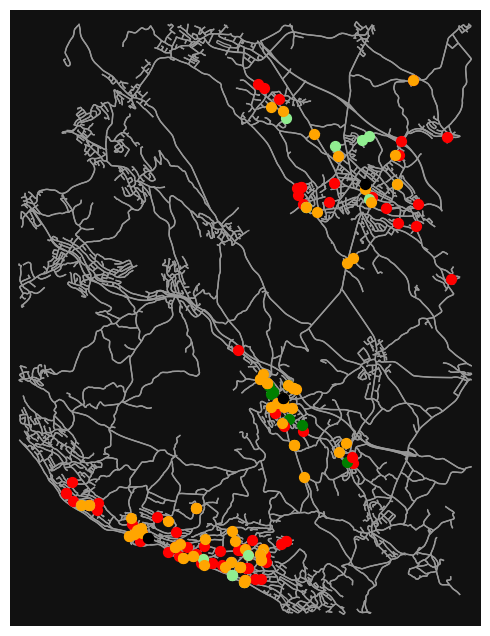

In [7]:
def plot_graph_with_demand_and_man_stops(G, demand_gdf, target_gdf, main_stops_gdf):
    """
    Plots a graph with demand points, target points, and main stops, and marks the nearest node for each demand point.
    
    Parameters:
        - G (networkx.MultiDiGraph): The street network graph.
        - demand_gdf (geopandas.GeoDataFrame): GeoDataFrame containing demand points.
        - target_gdf (geopandas.GeoDataFrame): GeoDataFrame containing target points.
        - main_stops_gdf (geopandas.GeoDataFrame): GeoDataFrame containing main stops.
    """
    # Plot des Straßennetzwerks ohne Node-Größe
    fig, ax = ox.plot_graph(G, node_size=0, show=False)
    
    # Markiere Demand Points und ihre nearest_nodes
    for i, demand_point in demand_gdf.iterrows():
        node_id = demand_point['nearest_node']
        node_position = (G.nodes[node_id]['x'], G.nodes[node_id]['y'])
        if i < 5:
            ax.scatter(*node_position, color='blue', s=50, zorder=5)  # Erste 5 Punkte blau
        elif i < 20:
            ax.scatter(*node_position, color='green', s=50, zorder=5)  # Nächste 15 Punkte grün
        else:
            ax.scatter(*node_position, color='red', s=50, zorder=5)  # Restliche Punkte rot
    
    # Markiere Target Points und ihre nearest_nodes
    for i, target_point in target_gdf.iterrows():
        node_id = target_point['nearest_node']
        node_position = (G.nodes[node_id]['x'], G.nodes[node_id]['y'])
        if i < 5:
            ax.scatter(*node_position, color='lightblue', s=50, zorder=5)  # Erste 5 Punkte blau
        elif i < 20:
            ax.scatter(*node_position, color='lightgreen', s=50, zorder=5)  # Nächste 15 Punkte grün
        else:
            ax.scatter(*node_position, color='orange', s=50, zorder=5)  # Target Points orange
        
    
    # Markiere Man Stops
    for node in main_stops_gdf['nearest_node']:
        node_position = (G.nodes[node]['x'], G.nodes[node]['y'])
        ax.scatter(*node_position, color='black', s=50, zorder=5)  # Man Stops in Schwarz
    
    # Anzeigen des Plots
    plt.show()

# Beispielaufruf der Funktion
plot_graph_with_demand_and_man_stops(G, sorted_demand_gdf, sorted_target_gdf, main_stops_gdf)


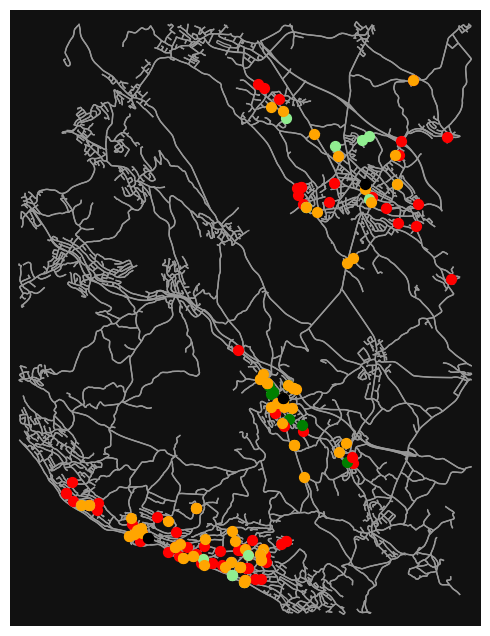

In [8]:
def plot_graph_with_demand_and_man_stops(G, demand_gdf, target_gdf, main_stops_gdf):
    """
    Plots a graph with demand points, target points, and main stops, and marks the nearest node for each demand point.
    
    Parameters:
        - G (networkx.MultiDiGraph): The street network graph.
        - demand_gdf (geopandas.GeoDataFrame): GeoDataFrame containing demand points.
        - target_gdf (geopandas.GeoDataFrame): GeoDataFrame containing target points.
        - main_stops_gdf (geopandas.GeoDataFrame): GeoDataFrame containing main stops.
    """
    # Plot des Straßennetzwerks ohne Node-Größe
    fig, ax = ox.plot_graph(G, node_size=0, show=False)
    
    # Markiere Demand Points und ihre nearest_nodes
    for i, demand_point in demand_gdf.iterrows():
        node_id = demand_point['nearest_node']
        node_position = (G.nodes[node_id]['x'], G.nodes[node_id]['y'])
        if i < 5:
            ax.scatter(*node_position, color='blue', s=50, zorder=5)  # Erste 5 Punkte blau
        elif i < 20:
            ax.scatter(*node_position, color='green', s=50, zorder=5)  # Nächste 15 Punkte grün
        else:
            ax.scatter(*node_position, color='red', s=50, zorder=5)  # Restliche Punkte rot
    
    # Markiere Target Points und ihre nearest_nodes
    for i, target_point in target_gdf.iterrows():
        node_id = target_point['nearest_node']
        node_position = (G.nodes[node_id]['x'], G.nodes[node_id]['y'])
        if i < 5:
            ax.scatter(*node_position, color='lightblue', s=50, zorder=5)  # Erste 5 Punkte blau
        elif i < 20:
            ax.scatter(*node_position, color='lightgreen', s=50, zorder=5)  # Nächste 15 Punkte grün
        else:
            ax.scatter(*node_position, color='orange', s=50, zorder=5)  # Target Points orange
        
    
    # Markiere Man Stops
    for node in main_stops_gdf['nearest_node']:
        node_position = (G.nodes[node]['x'], G.nodes[node]['y'])
        ax.scatter(*node_position, color='black', s=50, zorder=5)  # Man Stops in Schwarz
    
    # Anzeigen des Plots
    plt.show()

# Beispielaufruf der Funktion
plot_graph_with_demand_and_man_stops(G, demand_gdf, target_gdf, main_stops_gdf)


In [9]:
#Hilfsfunktionen

def create_section_trip_points(df):
    section_points_lists = []
    prev_nearest_node = None

    for index, row in df.iterrows():
        current_nearest_node = row['nearest_node']
        if prev_nearest_node is not None:
            section_points_lists.append([prev_nearest_node, current_nearest_node])
        prev_nearest_node = current_nearest_node

    return section_points_lists

def add_node_to_section(start_node, target_node, demand_node, section_trip_points):
    # Durchlaufe jede Liste in der Liste
    for sublist in section_trip_points:
        #print('sublist', sublist)
        # Überprüfe, ob beide Input-Elemente in der aktuellen Unterliste enthalten sind
        if start_node == sublist[0] and target_node == sublist[-1]:
            # Füge das dritte Input-Element zur Unterliste hinzu
            #print('vor', sublist)
            sublist.insert(-1, demand_node)  # Füge demand_node ein
            #print('nach',sublist)
            return section_trip_points  # Gib die gesamte Liste zurück, nachdem das Element hinzugefügt wurde
    return section_trip_points   # Falls keine passende Unterliste gefunden wurde, gib die unveränderte Liste zurück

def sort_sublists_by_shortest_path(sorted_section_trip_points, graph):
    sorted_sublists = []

    for sublist in sorted_section_trip_points:
        start_node = sublist[0]
        end_node = sublist[-1]  # Die end_node ist der letzte Eintrag der Unterliste

        # Finde die kürzeste Pfadlänge zwischen Start- und Endknoten
        shortest_path_length = nx.shortest_path_length(graph, start_node, end_node, weight='travel_time')

        # Sortiere die restlichen Knoten basierend auf ihrer Entfernung zum Startknoten
        sorted_nodes = sorted(sublist[1:-1], key=lambda x: nx.shortest_path_length(graph, start_node, x, weight='travel_time'))

        # Füge die sortierte Unterliste zur sortierten Liste hinzu
        sorted_sublist = [start_node] + sorted_nodes + [end_node]
        sorted_sublists.append(sorted_sublist)

    return sorted_sublists

def sort_sublists_by_shortest_path_with_target(sorted_section_trip_points, graph, demand_node, target_node):
    sorted_sublists = []

    for sublist in sorted_section_trip_points:
        start_node = sublist[0]
        end_node = sublist[-1]  # Die end_node ist der letzte Eintrag der Unterliste

        # Finde die kürzeste Pfadlänge zwischen Start- und Endknoten
        shortest_path_length = nx.shortest_path_length(graph, start_node, end_node, weight='travel_time')

        # Sortiere die restlichen Knoten basierend auf ihrer Entfernung zum Startknoten
        sorted_nodes = sorted(sublist[1:-1], key=lambda x: nx.shortest_path_length(graph, start_node, x, weight='travel_time'))

        # Überprüfe, ob demand_node und target_node in der Liste vorhanden sind
        if demand_node in sorted_nodes and target_node in sorted_nodes:
            # Füge demand_node vor target_node ein
            sorted_nodes.insert(sorted_nodes.index(target_node), demand_node)
            sorted_nodes.insert(sorted_nodes.index(demand_node) + 1, target_node)

        # Füge die sortierte Unterliste zur sortierten Liste hinzu
        sorted_sublist = [start_node] + sorted_nodes + [end_node]
        sorted_sublists.append(sorted_sublist)

    return sorted_sublists  



def calculate_travel_time_for_updated_section(demand_node, sorted_section_trip_points, graph):
    updated_section_index = None
    travel_time = 0
    
    # Finde den Index der aktualisierten Unterliste, die den demand_node enthält
    for i, sublist in enumerate(sorted_section_trip_points):
        if demand_node in sublist:
            updated_section_index = i
            break

    # Berechne die Reisezeit für die aktualisierte Unterliste
    if updated_section_index is not None:
        for i in range(len(sorted_section_trip_points[updated_section_index]) - 1):
            start_node = sorted_section_trip_points[updated_section_index][i]
            end_node = sorted_section_trip_points[updated_section_index][i + 1]
            travel_time += nx.shortest_path_length(graph, start_node, end_node, weight='travel_time')
    
    return travel_time

def calculate_travel_time_for_section_with_demand_target_nodes(sorted_section_trip_points, graph):
    travel_time = 0
    
    # Iteriere über jede Unterliste in sorted_section_trip_points
    for sublist in sorted_section_trip_points:
        # Iteriere über die Knoten in der Unterliste
        for i in range(len(sublist) - 1):
            start_node = sublist[i]
            end_node = sublist[i + 1]
            # Summiere die Reisezeit von start_node zu end_node
            travel_time += nx.shortest_path_length(graph, start_node, end_node, weight='travel_time')
    
    return travel_time


def remove_demand_node_from_sublist(start_node, target_node, demand_node, sorted_section_trip_points):
    # Iteriere über jede Unterliste in sorted_section_trip_points
    for sublist in sorted_section_trip_points:
        # Überprüfe, ob die demand_node in der Unterliste vorhanden ist
        if start_node == sublist[0] and target_node == sublist[-1] and demand_node in sublist and demand_node != sublist[0] and demand_node != sublist[-1]:
            # Entferne die demand_node aus der Unterliste
            sublist.remove(demand_node)
    
    return sorted_section_trip_points

def validate_nodes_in_data(nodes, main_stop_nodes, passengers_gdf):
    validated_nodes = []
    for list in nodes:
        section = []
        for node in list:
            # Überprüfe, ob der Knoten in den Hauptknoten oder in den Passagieren als Ursprung oder Ziel enthalten ist
            if node in main_stop_nodes['nearest_node'].values or node in passengers_gdf['origin'].values or node in passengers_gdf['destination'].values:
                section.append(node)
        validated_nodes.append(section)
    return validated_nodes




In [10]:
print(demand_gdf.head())

             timestamp gemeinde  passagier_nummer              geometry  \
53 2018-04-20 09:35:46   Meilen                54  POINT (8.656 47.267)   
55 2018-04-20 09:45:49   Meilen                56  POINT (8.661 47.265)   
64 2018-04-20 09:00:33   Meilen                65  POINT (8.624 47.278)   
37 2018-04-20 09:06:14    Uster                38  POINT (8.735 47.345)   
51 2018-04-20 09:33:52   Meilen                52  POINT (8.642 47.271)   

    nearest_node section  
53      35830593  (0, 1)  
55    6536087455  (0, 1)  
64     331865765  (0, 1)  
37    7054298833  (1, 2)  
51     218332079  (0, 1)  


In [11]:
print(main_stops_gdf)

   id    name              geometry  nearest_node
0   1  Meilen  POINT (8.644 47.269)      66861087
1   2     Egg  POINT (8.690 47.301)     393962506
2   3   Uster  POINT (8.717 47.351)     627939873
3   2     Egg  POINT (8.690 47.301)     393962506
4   1  Meilen  POINT (8.644 47.269)      66861087


In [12]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd

def process_demand_points(demand_nodes, target_nodes, main_stop_nodes):
    max_travel_time_per_section = 900  # 15 Minuten
    successful_trips = 0
    passengers = []


    section_trip_points = create_section_trip_points(main_stops_gdf)
    print(section_trip_points)
    
    # Iteriere über die Nachfrageknoten
    for demand_index, demand_row in demand_nodes.iterrows():
        demand_node = demand_row['nearest_node']
        demand_start_stop, demand_end_stop = demand_row['section']
        
        # Suche den Start-Hauptknoten des Demand-Knotens
        demand_start_stop_row = main_stop_nodes.loc[main_stop_nodes.index == demand_start_stop]
        nearest_node_demand_start = demand_start_stop_row['nearest_node'].values[0]
        #print('nearest_node_demand_start', nearest_node_demand_start)
        
        # Suche den Ziel-Hauptknoten des Demand-Knotens
        demand_end_stop_row = main_stop_nodes.loc[main_stop_nodes.index == demand_end_stop]
        nearest_node_demand_end = demand_end_stop_row['nearest_node'].values[0]

        # Füge demand_node zu den Abschnitts-Trip-Punkten hinzu
        section_trip_points = add_node_to_section(nearest_node_demand_start, nearest_node_demand_end, demand_node, section_trip_points)
        section_trip_points = sort_sublists_by_shortest_path(section_trip_points, G)
        #print('demand node', demand_node)
        #print('sorted_section_trip_points 1', section_trip_points)

        # Überprüfe, ob die Reisezeit pro Abschnitt die maximale Reisezeit pro Abschnitt überschreitet
        travel_time = calculate_travel_time_for_updated_section(demand_node, section_trip_points, G)
        #print('travel time:', travel_time)  
        if travel_time > max_travel_time_per_section:
            #print('travel time:', travel_time) 
            #print('demand_node', demand_node)
            section_trip_points = remove_demand_node_from_sublist(nearest_node_demand_start, nearest_node_demand_end, demand_node, section_trip_points)
            #print('sorted_section_trip_points 2', section_trip_points)
            continue

        # Finde die zugehörigen Zielknoten für diesen Demand-Knoten
        corresponding_target_node = target_nodes.loc[target_nodes['passagier_nummer'] == demand_row['passagier_nummer']]
        section_tuple = corresponding_target_node['section'].values[0]
        target_start_stop, target_end_stop = section_tuple
        target_node = corresponding_target_node['nearest_node'].values[0]

        # Suche den Start-Hauptknoten des Ziel-Knotens
        target_start_stop_row = main_stop_nodes.loc[main_stop_nodes.index == target_start_stop]
        nearest_node_target_start = target_start_stop_row['nearest_node'].values[0]
        #print('nearest_node_target_start', nearest_node_target_start)

        # Suche den Ziel-Hauptknoten des Ziel-Knotens
        target_end_stop_row = main_stop_nodes.loc[main_stop_nodes.index == target_end_stop]
        nearest_node_target_end = target_end_stop_row['nearest_node'].values[0]

        print('section_trip_points 3', section_trip_points)
        print('demand node', demand_node)
        print('target node', target_node)
        #print('start', nearest_node_target_start)
        #print('end', nearest_node_target_end)
        section_trip_points = add_node_to_section(nearest_node_target_start, nearest_node_target_end, target_node, section_trip_points)
        section_trip_points = sort_sublists_by_shortest_path_with_target(section_trip_points, G, demand_node, target_node)
        #print('target node', target_node)
        print('section_trip_points 4', section_trip_points)

        # Überprüfe, ob der target_node in der gleichen section ist wie der demand_node
        if nearest_node_demand_start == nearest_node_target_start and nearest_node_target_end == nearest_node_demand_end:
            #print('demand und target in der gleichen section')
            #print('demand:', demand_node, 'target:', target_node)
            # Berechne die Reisezeit für die aktualisierte Unterliste
            #travel_time_target = calculate_travel_time_for_section_with_demand_target_nodes(section_trip_points, G)
            travel_time_target = calculate_travel_time_for_updated_section(target_node, section_trip_points, G)
            #print('travel time:', travel_time_target)
            if travel_time_target > max_travel_time_per_section:
                #print('sorted_section_trip_points 1', section_trip_points)
                #print('target node', target_node)
                section_trip_points = remove_demand_node_from_sublist(nearest_node_demand_start, nearest_node_demand_end, demand_node, section_trip_points)
                #print('demand_node', demand_node)
                section_trip_points = remove_demand_node_from_sublist(nearest_node_target_start, nearest_node_target_end, target_node, section_trip_points)
                print('sorted_section_trip_points 5', section_trip_points)
                continue

        # Überprüfe, ob die Reisezeit pro Abschnitt die maximale Reisezeit pro Abschnitt überschreitet
        travel_time_target = calculate_travel_time_for_updated_section(target_node, section_trip_points, G)
        if travel_time_target > max_travel_time_per_section:
            print('section_trip_points 6:', section_trip_points)
            #print('travel time:', travel_time_target)
            section_trip_points = remove_demand_node_from_sublist(nearest_node_demand_start, nearest_node_demand_end, demand_node, section_trip_points)
            print('section_trip_points 6.1:', section_trip_points)
            section_trip_points = remove_demand_node_from_sublist(nearest_node_target_start, nearest_node_target_end, target_node, section_trip_points)
            print('section_trip_points 6.2:', section_trip_points)
            continue

        # Die Route zwischen Hauptknoten liegt innerhalb der Zeitbeschränkung
        successful_trips += 1
        print('section_trip_points 7:', section_trip_points)
        passengers.append({
                    'origin': demand_node,
                    'destination': target_node,
                    'id:': demand_row['passagier_nummer']-1,
                })
        
    passengers_gdf = gpd.GeoDataFrame(passengers)
    #print('section_trip_points 7:', section_trip_points)

    # Überprüfe die Validität der Knoten in den Abschnitten
    section_trip_points = validate_nodes_in_data(section_trip_points, main_stop_nodes, passengers_gdf)
    #print('section_trip_points 7:', section_trip_points)
        #print('demand:', demand_node, 'target:', target_node)
        #print('section_trip_points 5:', section_trip_points)
        #print('travel time:', travel_time, 'target:', travel_time_target )
    
    return section_trip_points, successful_trips, passengers_gdf

sorted_section_trip_points, successful_trips, passengers_gdf = process_demand_points(demand_gdf, target_gdf, main_stops_gdf)
print(sorted_section_trip_points)
print(successful_trips)
print(passengers_gdf)


[[66861087, 393962506], [393962506, 627939873], [627939873, 393962506], [393962506, 66861087]]
section_trip_points 3 [[66861087, 35830593, 393962506], [393962506, 627939873], [627939873, 393962506], [393962506, 66861087]]
demand node 35830593
target node 3104818251
section_trip_points 4 [[66861087, 35830593, 393962506], [393962506, 3104818251, 627939873], [627939873, 393962506], [393962506, 66861087]]
section_trip_points 7: [[66861087, 35830593, 393962506], [393962506, 3104818251, 627939873], [627939873, 393962506], [393962506, 66861087]]
section_trip_points 3 [[66861087, 35830593, 6536087455, 393962506], [393962506, 3104818251, 627939873], [627939873, 393962506], [393962506, 66861087]]
demand node 6536087455
target node 269549823
section_trip_points 4 [[66861087, 35830593, 6536087455, 393962506], [393962506, 3104818251, 627939873], [627939873, 269549823, 393962506], [393962506, 66861087]]
section_trip_points 7: [[66861087, 35830593, 6536087455, 393962506], [393962506, 3104818251, 6279

In [13]:
print(demand_gdf['nearest_node'])

53      35830593
55    6536087455
64     331865765
37    7054298833
51     218332079
         ...    
93      28105988
20    7260102355
36    1958250961
31     316654394
45     262999504
Name: nearest_node, Length: 97, dtype: int64


In [14]:
print(demand_gdf['section'])

53    (0, 1)
55    (0, 1)
64    (0, 1)
37    (1, 2)
51    (0, 1)
       ...  
93    (0, 1)
20    (1, 2)
36    (1, 2)
31    (1, 2)
45    (1, 2)
Name: section, Length: 97, dtype: object


In [15]:
print(target_gdf['section'])

53    (1, 2)
55    (2, 1)
64    (1, 2)
37    (2, 1)
51    (1, 0)
       ...  
93    (1, 2)
20    (2, 1)
36    (1, 0)
31    (1, 0)
45    (1, 0)
Name: section, Length: 97, dtype: object


In [16]:
print(target_gdf['nearest_node'])

53    3104818251
55     269549823
64    3104818251
37     393962506
51    1509996865
         ...    
93    1599382701
20    1631160222
36    1585002876
31    1585002876
45     411553280
Name: nearest_node, Length: 97, dtype: int64


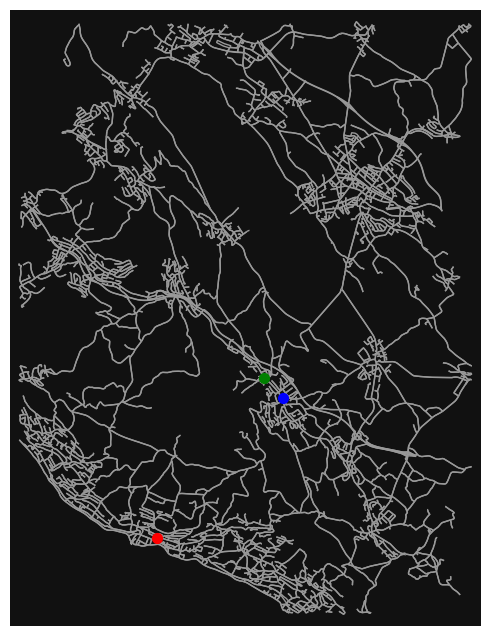

In [17]:
import matplotlib.pyplot as plt

def plot_nodes_on_graph(G, nodes_list, colors):
    """
    Plots the specified nodes on the graph with different colors.
    
    Parameters:
        - G (networkx.MultiDiGraph): The street network graph.
        - nodes_list (list): List of manual node IDs.
        - colors (list): List of colors corresponding to each node.
    """
    # Plot des Straßennetzwerks ohne Node-Größe
    fig, ax = ox.plot_graph(G, node_size=0, show=False)
    
    # Markiere die manuellen Nodes mit unterschiedlichen Farben
    for node_id, color in zip(nodes_list, colors):
        node_position = (G.nodes[node_id]['x'], G.nodes[node_id]['y'])
        ax.scatter(*node_position, color=color, s=50, zorder=5)
    
    # Anzeigen des Plots
    plt.show()

# Beispielaufruf der Funktion mit einer Liste von manuellen Nodes und Farben
manual_nodes_list = [1011611854, 1509996896, 393962506]
node_colors = ['red', 'green', 'blue']  # Beispielhafte Farben für die Punkte
plot_nodes_on_graph(G, manual_nodes_list, node_colors)


In [18]:
print(sorted_section_trip_points)

[[66861087, 218332079, 216510485, 216510485, 35830593, 28106331, 6536087455, 1605601293, 1605601293, 264890212, 264890212, 264890212, 1493171026, 1493171026, 1493171026, 216315152, 216315152, 393962506], [393962506, 3104818251, 1880125007, 320185206, 7054298833, 627939873], [627939873, 269549823, 352754276, 269549778, 989289011, 269550019, 1479539522, 393962506, 393962506], [393962506, 1509996865, 1509996865, 225062017, 216505567, 411514117, 1605601234, 418350219, 66861087]]


In [19]:
def calculate_passenger_travel_time(sorted_section_trip_points, graph, passengers_gdf):
    travel_times = []
    routes = []
    flattened_route = [item for sublist in sorted_section_trip_points for item in sublist]
    
    for index, row in passengers_gdf.iterrows():
        origin = row['origin']
        destination = row['destination']
        
        # Erstelle die Route für den Passagier
        route = []
        for point in flattened_route:
            if point == origin:
                route.append(point)
            elif point == destination:
                route.append(point)
                break
        
        # Berechne die Reisezeit entlang der Route
        travel_time = 0
        for i in range(len(route) - 1):
            travel_time += nx.shortest_path_length(graph, route[i], route[i + 1], weight='travel_time') / 60  # in Minuten
        
        # Füge die Reisezeit zum DataFrame hinzu
        travel_times.append(travel_time)
    
    passengers_gdf['travel_time'] = travel_times
    
    return passengers_gdf

# Beispielaufruf der Funktion
passengers_gdf = calculate_passenger_travel_time(sorted_section_trip_points, G, passengers_gdf)
print(passengers_gdf)


        origin  destination  id:  travel_time
0     35830593   3104818251   53     7.331667
1   6536087455    269549823   55    14.085000
2   7054298833    393962506   37     0.000000
3    218332079   1509996865   51     6.995000
4    264890212    418350219    7     7.385000
5    264890212    269549778    9     7.156667
6   1493171026    216505567    8     6.560000
7    216510485   1880125007   61     7.135000
8   1605601293   1509996865   57     7.181667
9   1605601293    352754276   68    13.488333
10  1493171026    411514117    1     6.386667
11   216510485    225062017   59     5.583333
12   216315152    989289011   18     9.060000
13   216315152    269550019   14     9.128333
14    28106331   1479539522   65    11.373333
15   320185206   1605601234   39    14.485000


In [20]:
print(sorted_section_trip_points)

[[66861087, 218332079, 216510485, 216510485, 35830593, 28106331, 6536087455, 1605601293, 1605601293, 264890212, 264890212, 264890212, 1493171026, 1493171026, 1493171026, 216315152, 216315152, 393962506], [393962506, 3104818251, 1880125007, 320185206, 7054298833, 627939873], [627939873, 269549823, 352754276, 269549778, 989289011, 269550019, 1479539522, 393962506, 393962506], [393962506, 1509996865, 1509996865, 225062017, 216505567, 411514117, 1605601234, 418350219, 66861087]]


In [21]:
def split_sections(input_list):
    section1 = input_list[0]
    section2 = input_list[1]
    section3 = input_list[2]
    section4 = input_list[3]

    return section1, section2, section3, section4

section1, section2, section3, section4 = split_sections(sorted_section_trip_points)

def route_node(G, sections):
    routes = []
    for section in sections:
        route = []
        for i in range(len(section) - 1):
            route.extend(nx.shortest_path(G, section[i], section[i + 1], weight='travel_time'))
        routes.append(route)
    return routes

# Beispielaufruf der Funktion mit einer einzelnen Sektion
route1 = route_node(G, [section1])
route2 = route_node(G, [section2])
route3 = route_node(G, [section3])
route4 = route_node(G, [section4])
print(route1)
print(type(route1))
combined_route = route1 + route2 + route3 + route4
flattened_route = [item for sublist in combined_route for item in sublist]
print(flattened_route)
#section1 = [[66861087, 218332079, 2503841517, 463491890, 1605601293, 1605601293, 6476376862, 393962506]]


[[66861087, 2509340820, 35830597, 35830795, 35830692, 35830580, 1612179560, 218332079, 218332079, 1612179560, 2503857926, 2503857906, 8921534196, 439228506, 463497613, 260378597, 463491370, 463491885, 216510485, 216510485, 216510485, 335482039, 35830593, 35830593, 335482039, 335482052, 28106336, 2083735023, 28106331, 28106331, 2314101421, 35830440, 35830442, 216505567, 6536087455, 6536087455, 216505567, 35830442, 2351296365, 35830545, 1605601293, 1605601293, 1605601293, 35830545, 463225668, 35830453, 207713913, 2504875494, 2504875332, 2504875221, 2504875390, 2504897006, 2504915659, 206189468, 632210423, 7121782608, 2511955657, 2511955641, 35831042, 2507646819, 206189293, 35831079, 206152111, 35831116, 1631987326, 35831136, 1599382670, 216320036, 393951118, 35831131, 264890212, 264890212, 264890212, 264890212, 1493171026, 1493171026, 1493171026, 1493171026, 264890212, 1509996838, 264890214, 264890215, 4083586896, 3342327338, 216315152, 216315152, 216315152, 3342327338, 35831160, 4083586

In [22]:
def calculate_section_travel_time(route, graph):
    total_travel_time = 0

    for node in route:
        for i in range(len(node) - 1):
            start_node = node[i]
            #print(start_node)
            end_node = node[i + 1]
            travel_time = nx.shortest_path_length(graph, start_node, end_node, weight='travel_time')
            total_travel_time += travel_time
    
    return total_travel_time

# Beispielaufruf der Funktion
travel_time1 = calculate_section_travel_time(route1, G)
travel_time2 = calculate_section_travel_time(route2, G)
travel_time3 = calculate_section_travel_time(route3, G)
travel_time4 = calculate_section_travel_time(route4, G)
print(travel_time1)
print(travel_time2)
print(travel_time3)
print(travel_time4)
total_travel_time = travel_time1 + travel_time2 + travel_time3 + travel_time4
print(total_travel_time)

802.5999999999998
884.9999999999995
851.7000000000002
864.3000000000004
3403.6000000000004


In [23]:
def calculate_passenger_travel_time(passengers_gdf, route, graph):
    travel_times = []

    for index, row in passengers_gdf.iterrows():
        origin = row['origin']
        destination = row['destination']
        
        # Finde den Abschnitt der Route zwischen Ursprung und Ziel des Passagiers
        section_route = route[route.index(origin): route.index(destination) + 1]

        # Berechne die Reisezeit entlang des Abschnitts der Route
        travel_time = sum(graph[u][v]['travel_time'] for u, v in zip(section_route[:-1], section_route[1:]))
        travel_times.append(travel_time)
    
    # Füge die berechneten Reisezeiten als neue Spalte zum DataFrame hinzu
    passengers_gdf['travel_time'] = travel_times
    
    return passengers_gdf

# Beispielaufruf der Funktion
passengers_gdf = calculate_passenger_travel_time(passengers_gdf, flattened_route, G)
print(passengers_gdf)


KeyError: 35830593

In [ ]:
def calculate_section_travel_time(route, graph):
    total_travel_time = 0

    for node in route:
        for i in range(len(node) - 1):
            start_node = node[i]
            end_node = node[i + 1]
            travel_time = nx.shortest_path_length(graph, start_node, end_node, weight='travel_time')
            total_travel_time += travel_time
    
    return total_travel_time

In [ ]:
def calculate_route_travel_distance(route, graph):
    total_travel_distance = 0

    for node in route:
        for i in range(len(node) - 1):
            start_node = node[i]
            end_node = node[i + 1]
            travel_distance = nx.shortest_path_length(graph, start_node, end_node, weight='length')
            total_travel_distance += travel_distance

    return total_travel_distance / 1000  # Umrechnung von Metern in Kilometer




# Beispielaufruf der Funktion
travel_distance1 = calculate_route_travel_distance(route1, G)
travel_distance2 = calculate_route_travel_distance(route2, G)
travel_distance3 = calculate_route_travel_distance(route3, G)
travel_distance4 = calculate_route_travel_distance(route4, G)
total_distance = travel_distance1 + travel_distance2 + travel_distance3 + travel_distance4

In [ ]:
#print(demand_gdf)
#print(section1)
#print(sorted_section_trip_points)
#print(target_gdf)

In [ ]:
def passenger_in_vehicle(section, demand_gdf, target_gdf):
    passengers_count = {}
    max_passengers = 0
    current_passengers = 0

    # Initialisierung des Dictionarys mit Nullen für alle Nodes in der Strecke
    for sublist in section:
        for node in sublist:
            passengers_count[node] = 0

    # Durchgehen der section und Inkrementieren/Dekrementieren der Passagieranzahl entsprechend der Fahrgastbewegungen
    for sublist in section:
        for node in sublist:
            if node in demand_gdf['nearest_node'].values:
                current_passengers += 1
                print('current_passengers', current_passengers)
            elif node in target_gdf['nearest_node'].values:
                current_passengers -= 1
                print('current_passengers', current_passengers)

            passengers_count[node] = current_passengers
            max_passengers = max(max_passengers, current_passengers)

    return max_passengers

# Beispielaufruf der Funktion
max_passengers = passenger_in_vehicle(sorted_section_trip_points, demand_gdf, target_gdf)
print(max_passengers)

current_passengers -1
current_passengers -2
current_passengers -3
current_passengers -2
current_passengers -1
current_passengers 0
current_passengers 1
current_passengers 2
current_passengers 1
current_passengers 2
current_passengers 3
current_passengers 4
current_passengers 3
current_passengers 2
current_passengers 1
current_passengers 0
current_passengers -1
current_passengers -2
4


TypeError: unsupported operand type(s) for /: 'float' and 'str'

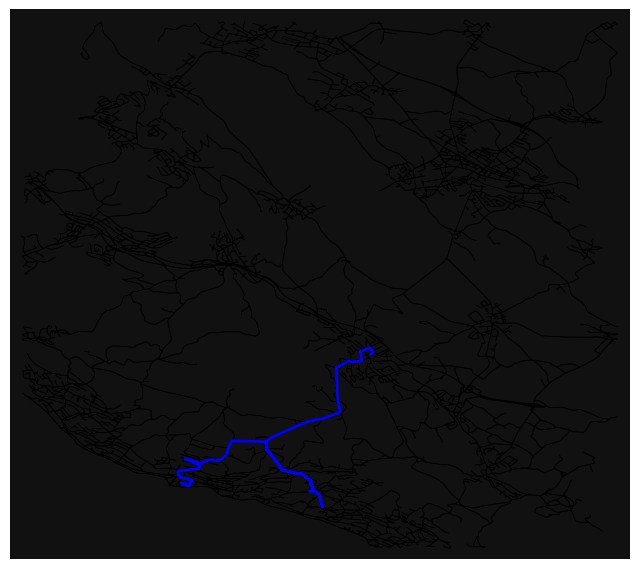

In [ ]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString

def calculate_travel_time_for_route(route, graph):
    travel_time = 0
    for i in range(len(route) - 1):
        u = route[i]
        v = route[i + 1]
        edge = graph.get_edge_data(u, v)
        travel_time += edge[0]['length'] / edge[0]['maxspeed']  # Annahme: Verwendung von Länge und Höchstgeschwindigkeit zur Berechnung der Reisezeit
    return travel_time

def plot_street_network_with_demand_points_and_routes(graph, mainstops_gdf, successful_trip_routes, successful_trip_points):
    # Plot des Straßennetzwerks
    fig, ax = ox.plot_graph(graph, node_size=0, edge_color='k', edge_linewidth=0.5, show=False)

    # Plot der erfolgreichen Fahrtrouten mit Reisezeit
    for route in successful_trip_routes:
        route_nodes = [(graph.nodes[node]['x'], graph.nodes[node]['y']) for node in route]
        route_line = LineString(route_nodes)
        route_gdf = gpd.GeoDataFrame({'geometry': [route_line]})
        route_gdf.plot(ax=ax, linewidth=2, color='blue')
        travel_time = calculate_travel_time_for_route(route, graph)
        ax.text(route_nodes[0][0], route_nodes[0][1], f'{travel_time:.2f} min', fontsize=8, color='blue')

    # Plot der Nachfragepunkte
    mainstops_gdf.plot(ax=ax, color='red', markersize=5)

    # Plot der erfolgreichen Trip-Punkte als separate Marker
    successful_trip_nodes_coords = [(graph.nodes[node]['x'], graph.nodes[node]['y']) for node in successful_trip_points]
    successful_trip_nodes_x, successful_trip_nodes_y = zip(*successful_trip_nodes_coords)
    ax.scatter(successful_trip_nodes_x, successful_trip_nodes_y, color='green', label='Erfolgreiche Trip-Punkte')

    plt.title('Straßennetzwerk mit Nachfragepunkten, erfolgreichen Fahrtrouten und erfolgreichen Trip-Punkten')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Beispielaufruf der aktualisierten Plot-Funktion
plot_street_network_with_demand_points_and_routes(G, ODPT_stops_wgs84_gdf, route1, section1)
plot_street_network_with_demand_points_and_routes(G, ODPT_stops_wgs84_gdf, route2, section2)
plot_street_network_with_demand_points_and_routes(G, ODPT_stops_wgs84_gdf, route3, section3)
plot_street_network_with_demand_points_and_routes(G, ODPT_stops_wgs84_gdf, route4, section4)


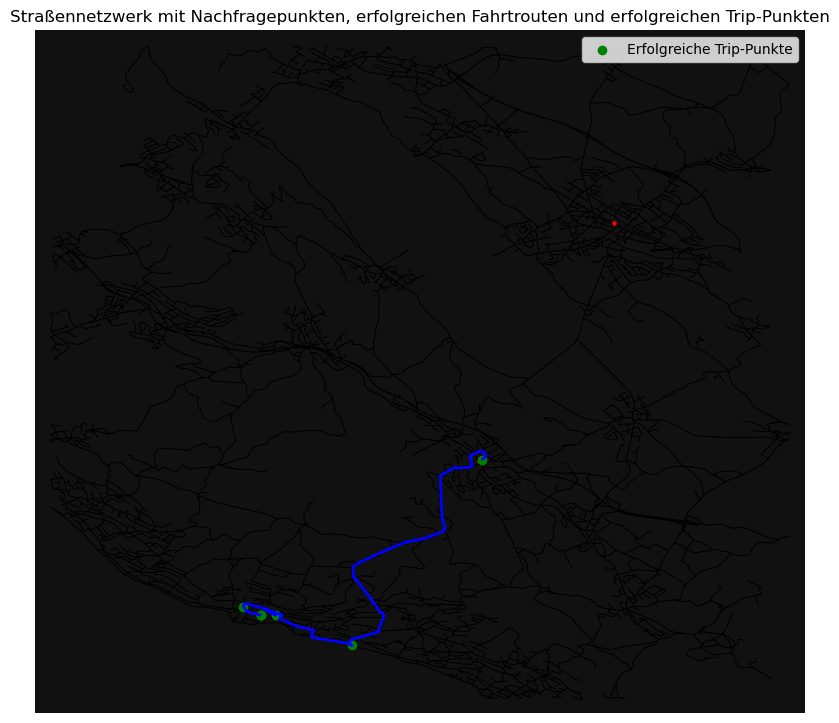

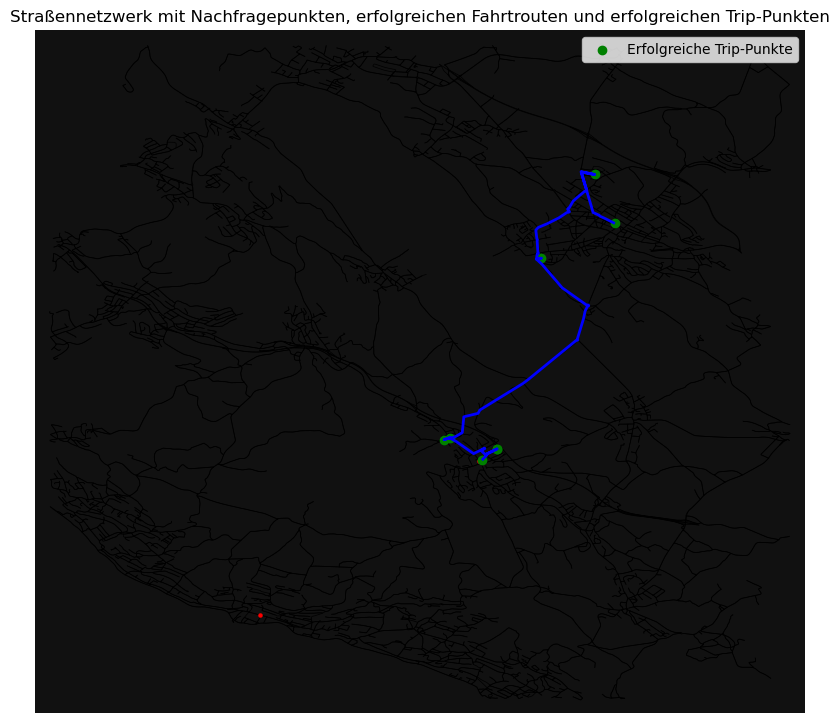

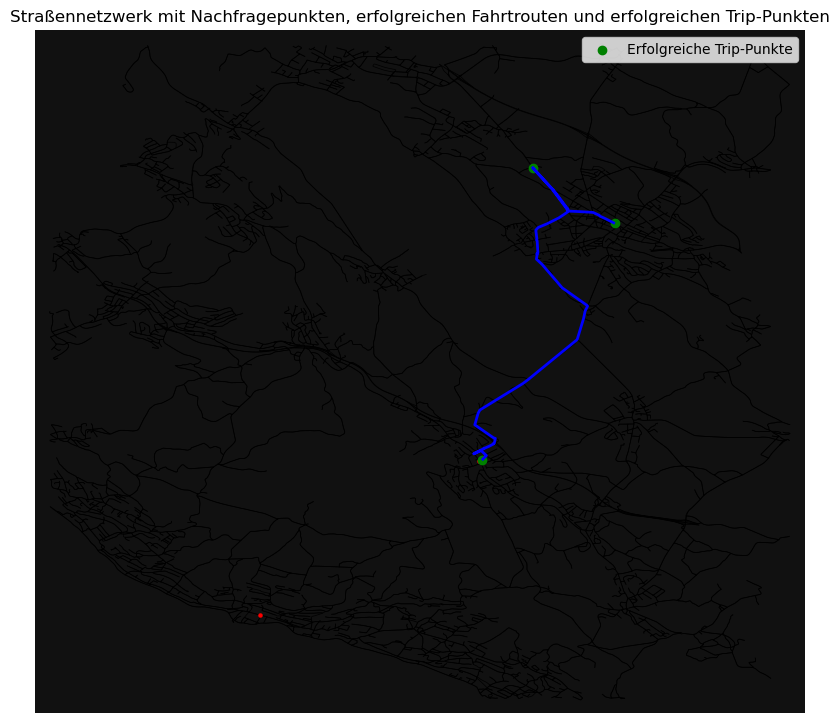

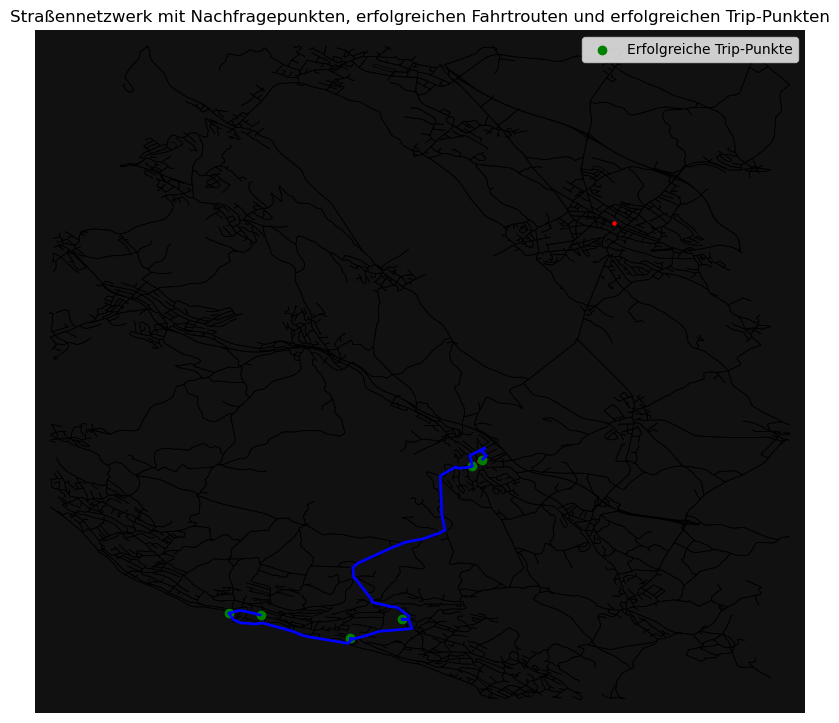

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import geopandas as gpd
from shapely.geometry import LineString, Point

def plot_street_network_with_demand_points_and_routes(graph, mainstops_gdf, successful_trip_routes, successful_trip_points):
    # Plot des Straßennetzwerks
    fig, ax = ox.plot_graph(graph, node_size=0, edge_color='k', edge_linewidth=0.5, show=False)

    # Plot der erfolgreichen Fahrtrouten
    for route in successful_trip_routes:
        route_nodes = [(graph.nodes[node]['x'], graph.nodes[node]['y']) for node in route]
        route_line = LineString(route_nodes)
        route_gdf = gpd.GeoDataFrame({'geometry': [route_line]})
        route_gdf.plot(ax=ax, linewidth=2, color='blue')

    # Plot der Nachfragepunkte
    mainstops_gdf.plot(ax=ax, color='red', markersize=5)

    # Plot der erfolgreichen Trip-Punkte als separate Marker
    successful_trip_nodes_coords = [(graph.nodes[node]['x'], graph.nodes[node]['y']) for node in successful_trip_points]
    successful_trip_nodes_x, successful_trip_nodes_y = zip(*successful_trip_nodes_coords)
    ax.scatter(successful_trip_nodes_x, successful_trip_nodes_y, color='green', label='Erfolgreiche Trip-Punkte')

    plt.title('Straßennetzwerk mit Nachfragepunkten, erfolgreichen Fahrtrouten und erfolgreichen Trip-Punkten')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Beispielaufruf der aktualisierten Plot-Funktion
plot_street_network_with_demand_points_and_routes(G, ODPT_stops_wgs84_gdf, route1, section1)
plot_street_network_with_demand_points_and_routes(G, ODPT_stops_wgs84_gdf, route2, section2)
plot_street_network_with_demand_points_and_routes(G, ODPT_stops_wgs84_gdf, route3, section3)
plot_street_network_with_demand_points_and_routes(G, ODPT_stops_wgs84_gdf, route4, section4)

In [ ]:
def process_demand_points(demand_nodes, target_nodes, main_stop_nodes):
    max_travel_time_per_section = 900  # 15 Minuten
    successful_trips = 0


    section_trip_points = create_section_trip_points(main_stops_gdf)
    print(section_trip_points)
    
    # Iteriere über die Nachfrageknoten
    for demand_index, demand_row in demand_nodes.iterrows():
        demand_node = demand_row['nearest_node']
        demand_start_stop, demand_end_stop = demand_row['section']
        #print('demand_node', demand_node)
        
        # Suche den Start-Hauptknoten des Demand-Knotens
        demand_start_stop_row = main_stop_nodes.loc[main_stop_nodes.index == demand_start_stop]
        nearest_node_demand_start = demand_start_stop_row['nearest_node'].values[0]
        
        # Suche den Ziel-Hauptknoten des Demand-Knotens
        demand_end_stop_row = main_stop_nodes.loc[main_stop_nodes.index == demand_end_stop]
        nearest_node_demand_end = demand_end_stop_row['nearest_node'].values[0]

        # Füge demand_node zu den Abschnitts-Trip-Punkten hinzu
        section_trip_points = add_node_to_section(nearest_node_demand_start, nearest_node_demand_end, demand_node, section_trip_points)
        #print('section_trip_points 1', section_trip_points)
        section_trip_points = sort_sublists_by_shortest_path(section_trip_points, G)
        #print('sortierte liste' , section_trip_points)

        # Berechne die Gesamtreisezeit für die sortierten Abschnitte
        travel_time = calculate_travel_time_for_updated_section(demand_node, section_trip_points, G)
        #print('zeit' , travel_time)

        # Überprüfe, ob die Reisezeit pro Abschnitt die maximale Reisezeit pro Abschnitt überschreitet
        if travel_time > max_travel_time_per_section:
            section_trip_points = remove_demand_node_from_sublist(demand_node, section_trip_points)
            #print('sorted_section_trip_points 2', section_trip_points)
            continue

        # Finde die zugehörigen Zielknoten für diesen Demand-Knoten
        corresponding_target_node = target_nodes.loc[target_nodes['passagier_nummer'] == demand_row['passagier_nummer']]
        #print('corresponding target node', corresponding_target_node)
        section_tuple = corresponding_target_node['section'].values[0]
        target_start_stop, target_end_stop = section_tuple
        target_node = corresponding_target_node['nearest_node'].values[0]
        print('target node', target_node)

        # Suche den Start-Hauptknoten des Ziel-Knotens
        target_start_stop_row = main_stop_nodes.loc[main_stop_nodes.index == target_start_stop]
        nearest_node_target_start = target_start_stop_row['nearest_node'].values[0]

        # Suche den Ziel-Hauptknoten des Ziel-Knotens
        target_end_stop_row = main_stop_nodes.loc[main_stop_nodes.index == target_end_stop]
        nearest_node_target_end = target_end_stop_row['nearest_node'].values[0]

        section_trip_points = add_node_to_section(nearest_node_target_start, nearest_node_target_end, target_node, section_trip_points)
        print('section_trip_points 1', section_trip_points)
        section_trip_points = sort_sublists_by_shortest_path(section_trip_points, G)
        #print('sortierte liste' , sorted_section_trip_points)

        # Berechne die Gesamtreisezeit für die sortierten Abschnitte
        travel_time_target = calculate_travel_time_for_updated_section(target_node, section_trip_points, G)
        print(travel_time_target)

        # Überprüfe, ob die Reisezeit pro Abschnitt die maximale Reisezeit pro Abschnitt überschreitet
        if travel_time_target > max_travel_time_per_section:
            section_trip_points = remove_demand_node_from_sublist(target_node, section_trip_points)
            print('sorted_section_trip_points 2', section_trip_points)
            continue

        # Die Route zwischen Hauptknoten liegt innerhalb der Zeitbeschränkung
        successful_trips += 1
    
    return section_trip_points, successful_trips

sorted_section_trip_points, successful_trips = process_demand_points(demand_gdf, target_gdf, main_stops_gdf)
print(sorted_section_trip_points)
print(successful_trips)




In [ ]:
import pandas as pd
from shapely.geometry import Point

# Daten
data = {
    'origin': [
        Point(2694445.847, 1239636.790),
        Point(2695261.014, 1238557.990),
        Point(2696740.952, 1244961.505),
        Point(2696520.307, 1243025.691),
        Point(2696695.566, 1244176.812),
        Point(2693448.159, 1236047.724),
        Point(2694324.039, 1236339.853)
    ],
    'destination': [
        Point(2692086.397963089, 1235886.8099935767),
        Point(2696533.6082410826, 1244064.951446884),
        Point(2692646.9226403986, 1236056.8590393714),
        Point(2690794.690388481, 1236160.4874132331),
        Point(2694609.751670501, 1239613.9681586307),
        Point(2694638.896568783, 1239544.2010287007),
        Point(2691029.6196551155, 1236034.1294361514)
    ],
    'start': [
        Point(2694600.923717079, 1239702.3453705623),
        Point(2694957.86900558, 1238374.380029196),
        Point(2696659.1654481813, 1244823.469943103),
        Point(2696196.6005254313, 1243162.8875784155),
        Point(2696411.2395658926, 1243957.7005632187),
        Point(2693795.5221591513, 1236390.8376487773),
        Point(2694359.5333796265, 1236444.631419684)
    ],
    'end': [
        Point(2692164.1308537913, 1235952.1894149834),
        Point(2696411.2395658926, 1243957.7005632187),
        Point(2692625.7134854477, 1236089.9630500209),
        Point(2691216.441718935, 1236097.1299538906),
        Point(2694763.3505828544, 1240053.1639007016),
        Point(2694619.7367313113, 1239083.0992379861),
        Point(2691216.441718935, 1236097.1299538906)
    ],
    'timestamp': [
        '2018-04-20T09:35:07',
        '2018-04-20T09:23:02',
        '2018-04-20T09:04:55',
        '2018-04-20T09:28:59',
        '2018-04-20T09:37:11',
        '2018-04-20T09:35:14',
        '2018-04-20T09:31:25'
    ],
    'travel_time': [35, 25, 49, 34, 18, 17, 20]
}

# DataFrame erstellen
df = pd.DataFrame(data)

print(df)


                            origin  \
0   POINT (2694445.847 1239636.79)   
1   POINT (2695261.014 1238557.99)   
2  POINT (2696740.952 1244961.505)   
3  POINT (2696520.307 1243025.691)   
4  POINT (2696695.566 1244176.812)   
5  POINT (2693448.159 1236047.724)   
6  POINT (2694324.039 1236339.853)   

                                     destination  \
0   POINT (2692086.397963089 1235886.8099935767)   
1   POINT (2696533.6082410826 1244064.951446884)   
2  POINT (2692646.9226403986 1236056.8590393714)   
3   POINT (2690794.690388481 1236160.4874132331)   
4   POINT (2694609.751670501 1239613.9681586307)   
5   POINT (2694638.896568783 1239544.2010287007)   
6  POINT (2691029.6196551155 1236034.1294361514)   

                                           start  \
0   POINT (2694600.923717079 1239702.3453705623)   
1     POINT (2694957.86900558 1238374.380029196)   
2   POINT (2696659.1654481813 1244823.469943103)   
3  POINT (2696196.6005254313 1243162.8875784155)   
4  POINT (2696411.

In [ ]:
mean = df['travel_time'].mean()
print(mean)

28.285714285714285
